 ###

# $\text{Arrow Debreu European Option Pricing}$

### I: Introduction. 
> This notebook implements the Arrow-Debreu [model](https://en.wikipedia.org/wiki/Arrow%E2%80%93Debreu_model) to price European options and detect arbitrage opportunities, alongside calculating the risk free profit. The ideas is to consider every possible contingent claim based on [sate prices](https://en.wikipedia.org/wiki/State_prices).

### I.I: Definitions.
* **Arrow-Debreu Model Wiki [Page](https://en.wikipedia.org/wiki/Arrow%E2%80%93Debreu_model)**
* **Terminal States** - Possible future prices of the underlying asset. Denoted $S = \{S_1, S_2, \ldots, S_n\}$ This is a discrete approximation for what is actually a continuous distribution (ex. 80, 90, 100, 110).
* **Payoff Vector** - Each option corresponds to a row vector of payoffs across terminal states. These row vectors make up the matrix $F$.
* **[State Price](https://en.wikipedia.org/wiki/State_prices)** - Also referred to as Arrow Debreu price the present value of recieving 1 dollar iff the underlying price at expiration ends up in that specific terminal state. If $ S \in \{80, 90, 100\} $, then the state prices $\vec{\pi} = [\pi_{80}, \pi_{90}, \pi_{100}]$ tell us today's price of recieving 1 dollar in the future is the underlyig ends at that subscript.
* **[Risk-Neutral Probailities](https://www.investopedia.com/terms/r/risk-neutral-probabilities.asp)** - the probabilities of possible future outcomes that have been asjusted for risk, denoted $q_i=\frac{\pi_{i}}{e^{-rT}}=\pi_{i} \cdot e^{rT}$
* **[Complete Market](https://en.wikipedia.org/wiki/Complete_market)** - a market with negligible transaction costs, perfect information and a set price for every asset in every possible state. For practical purposes some of these assumptions may be altered.

### II: General Form.

### $$F\vec{\pi} = \vec{p}$$

* $\vec{p}$ - a vector of current call/put prices (all the same maturity). <br>
* ${F}$ - ${m \times n}$ matrix of payoffs with $m$ options and $n$ states. Where each row corresponds to an option and each column corresponds to a possible terminal state of the underlying.
* $\vec{\pi}$ - a vector of state prices.
> Each observed option price is a weighted average of possible future payoffs, weighted by the present value of receiving 1 dollar in that state. The payoff matrix $F$ maps states to payoffs. The vector $\vec{\pi}$ maps states to dollar values today. Then, multiplying them gives the current prices of the options.

### II.I: Find $\vec{\pi}$ (Matrix Inversion)

### $$\vec{\pi} = F^{-1}\vec{p}$$

> At this step we invert the payoff matrix using NumPy. However, more ofthen than not, the payoff matrix is not invertable for various reasons, which forces us to use the least squares method. 

### II.II: Find $\vec{\pi}$ (Least Squares Method)

### $$F^T F \vec{\pi} = F^T \vec{p} \implies \vec{\pi} = (F^TF)^{-1} F^T\vec{p}$$

> LSM does not necessarily give the exact solution, rather the best approximation. This fact is embedded in the name "Least Squares", referring to minimizing the sum of the squares of the residuals (the line of best fit for higher dimention matrices).

### III: Fair Price.

### $$\alpha = \displaystyle\sum_{i=1}^n{\pi_i} \cdot f(S_{i}) = \langle \vec{\pi} \cdot \vec{f(S_i)} \rangle$$

* $\alpha$ - the fair price of an option. <br>
* $\pi_{i}$ - the Arrow Debreu price for state $i$. <br>
* $f(S_{i})$ - the payoff of terminal price $S$ at state $i$ of option $p$.
* Note: the summation version is equivalent to the dot product version.
  
* For call options with strike K:
<center>$f_c(S_{i}) = max(0, S_i - K)$ </center>
* For put options with strike K: 
<center>$f_p(S_{i}) = max(0, K - S_i)$</center>

### III.I: Probabilites.

### $$q_i=\pi_{i} \cdot e^{rT} \implies \displaystyle\sum_{i}^n{q_i}=1$$

> This works because each $\pi_i$ is what you'd pay today to recieve 1 dollar iff state $i$ occurs according to the market implied likelihood. And since everything is scaled to a dollar that becomes the implied probability when adjusted for the time value of money. And since $q$ is risk-neutral probabilities, its elements must sum to one.

### V: Data.

* <ins>Strike Prices</ins>: $K = \{K_1, K_2, \ldots , K_n\}$. They define the contracts used to construct the system (preferably the same for calls and puts).
* <ins>Call/Put Options Premiums</ins>: $ \vec{p} = [p_1, p_2, \ldots, p_n]$ i.e the current market price of options at each $K_{i}$.
* <ins>Underlying Spot Price</ins>: $S$ to help define reasonable strike prices.
* <ins>Time to Maturity</ins>: $T$ (in years).
* <ins>Risk-Free Rate</ins>: $r$ (T-bill/note/bond yeild).
* <ins>Discounting Factor</ins>: $e^{-rT}$ Continuously compounding discounting factor. Optional for short-term, but necessary for risk-neutral probabilities.

### VI: Implementation:

In [253]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import nnls

In [254]:
ticker = 'AAPL'
ticker_data = yf.Ticker(ticker)
expiry = ticker_data.options[4]
print('Using Expiry:', expiry)
chain = ticker_data.option_chain(expiry)
calls = chain.calls #the pricing will be based just on calls which takes away a bit of accuracy but is not crusial in this case.

Using Expiry: 2025-06-13


In [255]:
spot = ticker_data.history(period='1d')['Close'].iloc[-1]
possible_states = possible_states = np.round(np.linspace(spot - 50, spot + 50, 21, dtype=int))
print('Using Spot:', spot)
print(f'Will be pricing options for the following spot prices: {possible_states} expiring on {expiry} (same as options used for analysis)')

Using Spot: 210.9499969482422
Will be pricing options for the following spot prices: [160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245
 250 255 260] expiring on 2025-06-13 (same as options used for analysis)


In [256]:
available_strikes = sorted(calls["strike"])
print('Available Strikes:\n', available_strikes)

Available Strikes:
 [110.0, 130.0, 135.0, 140.0, 150.0, 155.0, 160.0, 165.0, 170.0, 175.0, 180.0, 185.0, 190.0, 195.0, 200.0, 205.0, 210.0, 215.0, 220.0, 225.0, 230.0, 235.0, 240.0, 245.0, 250.0, 255.0, 260.0, 265.0, 270.0, 275.0, 280.0, 295.0, 305.0, 310.0]


In [257]:
atm_index = min(range(len(available_strikes)), key=lambda i: abs(available_strikes[i] - spot))
print('Index of the closest strike price to the spot price:', atm_index)

Index of the closest strike price to the spot price: 16


In [258]:
lower_bound = max(atm_index - 10, 0)
upper_bound = min(atm_index + 11, len(available_strikes))
print(f'Lower index bound: {lower_bound}\n', f'Upper undex bound: {upper_bound}')

Lower index bound: 6
 Upper undex bound: 27


In [259]:
chosen_strikes = available_strikes[lower_bound:upper_bound]
chosen_strikes = np.array(chosen_strikes)
print(f'Selected {len(chosen_strikes)} strikes around ATM:', '\n', sorted(chosen_strikes))

Selected 21 strikes around ATM: 
 [160.0, 165.0, 170.0, 175.0, 180.0, 185.0, 190.0, 195.0, 200.0, 205.0, 210.0, 215.0, 220.0, 225.0, 230.0, 235.0, 240.0, 245.0, 250.0, 255.0, 260.0]


In [320]:
chosen_calls = calls[calls['strike'].isin(chosen_strikes)].copy().reset_index(drop=True)
chosen_calls = chosen_calls[['strike', 'bid', 'ask']]
chosen_calls.head()

,strike,bid,ask
0,160.0,51.25,51.85
1,165.0,46.10,46.85
2,170.0,41.30,41.95
3,175.0,36.25,37.55
4,180.0,31.80,32.25


In [326]:
chosen_calls['price_vector'] = (chosen_calls['bid']+chosen_calls['ask'])/2
chosen_calls = chosen_calls[['strike', 'price_vector']]
chosen_calls.head()

,strike,price_vector
0,160.0,51.550
1,165.0,46.475
2,170.0,41.625
3,175.0,36.900
4,180.0,32.025


In [262]:
strikes = chosen_calls["strike"].values
price_vector = chosen_calls["price_vector"].values
print(strikes)
print(price_vector)

[160. 165. 170. 175. 180. 185. 190. 195. 200. 205. 210. 215. 220. 225.
 230. 235. 240. 245. 250. 255. 260.]
[51.55  46.475 41.625 36.9   32.025 27.125 22.475 18.15  14.    10.3
  7.15   4.7    2.86   1.675  0.975  0.575  0.355  0.23   0.165  0.12
  0.095]


In [328]:
terminal_prices = strikes.copy()
call_payoff_matrix = np.maximum(possible_states - chosen_strikes[:, None], 0)
put_payoff_matrix  = np.maximum(chosen_strikes[:, None] - possible_states, 0)
print(f'Call payoff matrix piece:\n {call_payoff_matrix[:5,:5]}\n Put payoff matrix piece\n {put_payoff_matrix[:5,:5]}\n Payoff matrices shape: {call_payoff_matrix.shape}')


Call payoff matrix piece:
 [[ 0.  5. 10. 15. 20.]
 [ 0.  0.  5. 10. 15.]
 [ 0.  0.  0.  5. 10.]
 [ 0.  0.  0.  0.  5.]
 [ 0.  0.  0.  0.  0.]]
 Put payoff matrix piece
 [[ 0.  0.  0.  0.  0.]
 [ 5.  0.  0.  0.  0.]
 [10.  5.  0.  0.  0.]
 [15. 10.  5.  0.  0.]
 [20. 15. 10.  5.  0.]]
 Payoff matrices shape: (21, 21)


In [330]:
#state_prices, _, _, _ = np.linalg.lstsq(call_payoff_matrix, price_vector, rcond=None)
state_prices, _ = nnls(call_payoff_matrix, price_vector)
normalized_state_prices = state_prices/np.sum(state_prices)

r=0.0438 #look up current 1m T-bill rate
T=30/365
probabilities = state_prices * np.e**(r*T)

In [334]:
print(f'The sum of (q): {np.sum(probabilities)} ≠ 1, suggests some error such as discretization, or arbitrage')
print(f'The sum of normalized state prices: {np.sum(normalized_state_prices)}')
print('p.s. "np.linalg.lstsq" was resulting in some values being negative so I had to use "scipy.optimize.nnls" i.e non-negative least squares.')

The sum of (q): 1.0156497656364043 ≠ 1, suggests some error such as discretization, or arbitrage
The sum of normalized state prices: 1.0
p.s. "np.linalg.lstsq" was resulting in some values being negative so I had to use "scipy.optimize.nnls" i.e non-negative least squares.


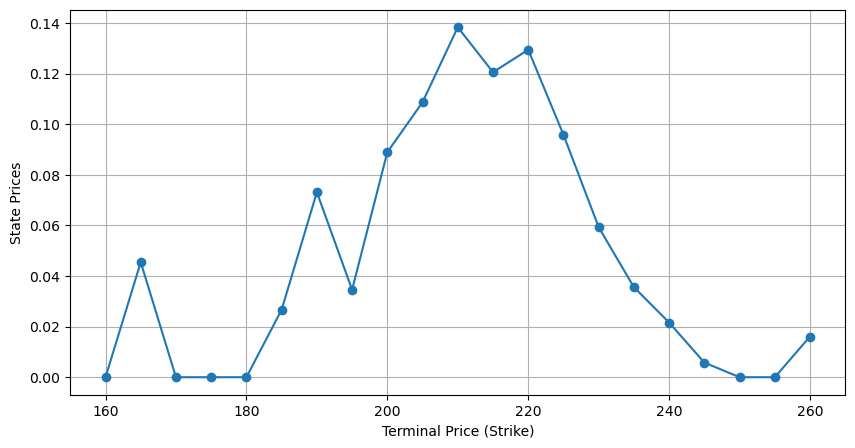

In [338]:
plt.figure(figsize=(10, 5))
plt.plot(terminal_prices, normalized_state_prices, marker='o')
plt.xlabel('Terminal Price (Strike)')
plt.ylabel('State Prices')
plt.grid(True)
plt.show()

In [340]:
call_prices = call_payoff_matrix @ normalized_state_prices
put_prices = put_payoff_matrix @ normalized_state_prices

call_prices = pd.DataFrame({
    'Strike': chosen_strikes,
    '$Call': call_prices,
    '$Put': put_prices
})
print('Once again, the modeled prices below are based solely on calls so they may not represent the full picture.')
call_prices


Once again, the modeled prices below are based solely on calls so they may not represent the full picture.


,Strike,$Call,$Put
0,160.0,50.938735,0.000000
1,165.0,45.938735,0.000000
2,170.0,41.166008,0.227273
3,175.0,36.393281,0.454545
4,180.0,31.620553,0.681818
5,185.0,26.847826,0.909091
6,190.0,22.208498,1.269763
7,195.0,17.934783,1.996047
8,200.0,13.833992,2.895257
9,205.0,10.177866,4.239130
